# August 14th, 2018
## Benjamin Adam Catching
## Andino Lab
## Polio-virus DIPs Project

Convert yesterday's code to a function that can automatically generate bright-field and GFP images of segmented cells. 

In [101]:
# Import necessary packages
import glob
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import seaborn as sns
import skimage
import skimage.filters
import skimage.measure
import skimage.segmentation
import skimage.feature
import scipy.ndimage as ndi
import scipy
import pandas as pd
import os

In [3]:
# Define the location of the files
bulk_cell_dir = 'data/07.27_HeLa_TIP_Hong/'

# Define the six directories that contain image files
set_1 = '#1/10x-[0-9].tif'
set_2 = '#2/10x-[0-9].tif'
set_3 = '#3/10x-[0-9].tif'
set_4 = '#4/10x-[0-9].tif'
set_5 = '#5/10x-[0-9].tif'

In [4]:
# Read in the files
group_1 = sorted(glob.glob(bulk_cell_dir + set_1))
group_2 = sorted(glob.glob(bulk_cell_dir + set_2))
group_3 = sorted(glob.glob(bulk_cell_dir + set_3))
group_4 = sorted(glob.glob(bulk_cell_dir + set_4))
group_5 = sorted(glob.glob(bulk_cell_dir + set_5))

In [43]:
def get_10x_droplets(filename):
    """
    Process the 10X file to return a lists of images representing the droplets
    that contain cells, both the bright-field and GFP channels.
    
    Parameters
    ----------
    filename:
        The name the 10X, RGB .tif image of the bulk droplet with cells
        
    Return
    ------
    bright_droplet_props:
        A list of 2D, gray-scale, numpy arrays representing the bright-field 
        channel of the bulk droplets
    gfp_droplet_props:
        A list of 2D, gray-scale, numpy arrays representing the bright-field
        channel of the bulk droplets 
    """
    # Read in the bright-field and GFP images
    entire_image = skimage.io.imread(filename)
    image_bright = entire_image[:, :, 0]
    image_gfp = entire_image[:, :, 1]
    
    # Find the Otsu threshold
    bright_thresh_otsu = skimage.filters.threshold_otsu(image_bright)

    # Label thresholded images
    bright_threshold = image_bright > bright_thresh_otsu
    image_labeled, number_labels = skimage.measure.label(bright_threshold,
                                                         background=0,
                                                         return_num=True)

    # Get the properties of the labeled regions
    image_props = skimage.measure.regionprops(image_labeled)

    # Create a blank region of the original image
    image_dimensions = image_bright.shape
    blank_background = np.zeros(image_dimensions)
    # Go through props, filter for round droplets
    for index, prop in enumerate(image_props):
        # If the region properties are within the threshold
        if prop.area >= 400 and prop.eccentricity <= 0.5:
            # Select the region
            temp_seg = image_labeled == index + 1
            filled_seg = temp_seg
            # Add the temp region
            blank_background = blank_background + filled_seg

    # Fill the holes of the image
    image_droplets = ndi.binary_fill_holes(blank_background)

    # From the filled droplets, create labeled regions with properties
    labeled_droplets, number_droplets = skimage.measure.label(image_droplets,
                                                              background=0,
                                                              return_num=True)
    bright_droplet_props = skimage.measure.regionprops(labeled_droplets,
                                                       image_bright)
    gfp_droplet_props = skimage.measure.regionprops(labeled_droplets,
                                                    image_gfp)
    bw_droplets = []
    gfp_droplets = []
    for i in range(number_droplets):
        # Add brightfield image and gfp to lists
        bw_droplet = bright_droplet_props[i].intensity_image
        bw_droplets.append(bw_droplet)
        
        # As the marker only appears where the green channel is substantially 
        # greater than the other two channels, the GFP threshold can be
        # determined by the maximum value of the bright-field channel
        gfp_thresh = bw_droplet.max()
        gfp_droplets.append((gfp_droplet_props[i].intensity_image > gfp_thresh) *
                            gfp_droplet_props[i].intensity_image)
        
    return bw_droplets, gfp_droplets

In [44]:
# Get two lists of test images to process, same as yesterday
test_bw, test_gfp = get_10x_droplets(group_1[0])

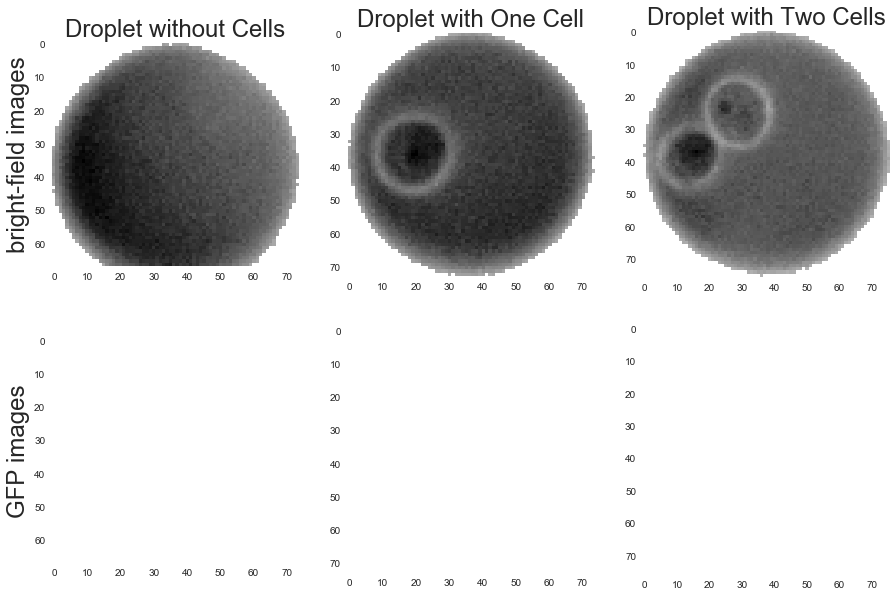

In [45]:
# Display the same droplets from yesterday (no cell, one cell, two cells)

# Define the three bright-field droplet images
test_bw_droplets = [test_bw[x] for x in [162, 139, 128]]
# Define the three GFP droplet images
test_gfp_droplets = [test_gfp[x] for x in [162, 139, 128]]
# Define the three names
three_types = ['Droplet without Cells', 
               'Droplet with One Cell', 
               'Droplet with Two Cells']

with sns.axes_style('dark'):
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    _ = ax[0, 0].set_ylabel('bright-field images', size=24)
    _ = ax[1, 0].set_ylabel('GFP images', size=24)
    for i in range(3):
        _ = ax[0, i].imshow(test_bw_droplets[i])
        _ = ax[1, i].imshow(test_gfp_droplets[i])
        _ = ax[0, i].set_title(three_types[i], size=24)
    plt.show()

Using the above images, create and test a function that isolates and returns the brightfield and GFP channels of enclosed cells.

In [268]:
def cell_segment_10x(bw_droplet, gfp_droplet):
    """
    
    :param bw_droplet: 
    :param gfp_droplet: 
    Return
    ------
    
    """
    
    # Create eroded mask for the droplet
    bf_mask = bw_droplet != 0
    bf_mask = ndi.binary_erosion(bf_mask, iterations=4) 
    
    # Apply the Prewitt method to the bright-field droplet
    bf_prewitt = skimage.filters.prewitt(bw_droplet, mask=bf_mask) 
    
    # Threshold with Otsu's method 
    thresh_otsu = skimage.filters.threshold_otsu(bf_prewitt)
    thresh_droplet = bf_prewitt > thresh_otsu
    
    # Get the region properties of the droplets
    labels = skimage.measure.label(thresh_droplet, background=0)
    edge_props = skimage.measure.regionprops(labels)
    
    # Filter the labeled regions by area and eccentricity
    blank_region = np.zeros(thresh_droplet.shape)
    for index, prop in enumerate(edge_props):
        if prop.area > 100 and prop.area < 1000 and prop.eccentricity <= 0.9:
            temp_seg = labels == index + 1
            blank_region = blank_region + temp_seg
    
    # If there are not any cells present, return None for both the 
    # bright-field and GFP channels
    if blank_region.max() == 0:
        return None, None
    else:
        # Close any holes
        closed_cells = ndi.binary_closing(blank_region)
        
        # Fill and erode 
        filled_cells = ndi.binary_fill_holes(closed_cells)
        eroded_cells = ndi.binary_erosion(filled_cells)
        
        # Separate any multiple cells
        # Use watershed 
        temp_distances = ndi.distance_transform_edt(eroded_cells)
        # Find the 
        local_maxi = skimage.feature.peak_local_max(temp_distances,
                                                    indices=False,
                                                    footprint=np.ones((20, 20)),
                                                    labels=eroded_cells)
        markers = skimage.measure.label(local_maxi)

        cell_labels = skimage.segmentation.watershed(~eroded_cells, 
                                                     markers, 
                                                     mask=eroded_cells)
        #print(cell_labels.max())
        # If only one cell, return the two channels in two lists
        if cell_labels.max() == 1:
            # Get the segmented cell intensity image of both channels
            bw_cell = [cell_labels * bw_droplet]
            gfp_cell = [cell_labels * gfp_droplet]
            
            return bw_cell, gfp_cell
        # If there are more than one cell in the droplet, create two
        # lists of multiple segmented cell representing two channels
        elif cell_labels.max() > 1:
            # Get the number of cells
            num_cells = cell_labels.max()
            # Initialize the lists
            bw_cells = []
            gfp_cells = []
            # Iterate over the cell masks
            print(num_cells)
            for i in range(num_cells):
                print(i)
                # A new segmented cell mask
                temp_cell = cell_labels == i + 1
                
                # Add to the lists of segmented cell intensity images
                bw_cells.append(temp_cell * bw_droplet)
                gfp_cells.append(temp_cell * gfp_droplet)
                
            return bw_cells, gfp_cells

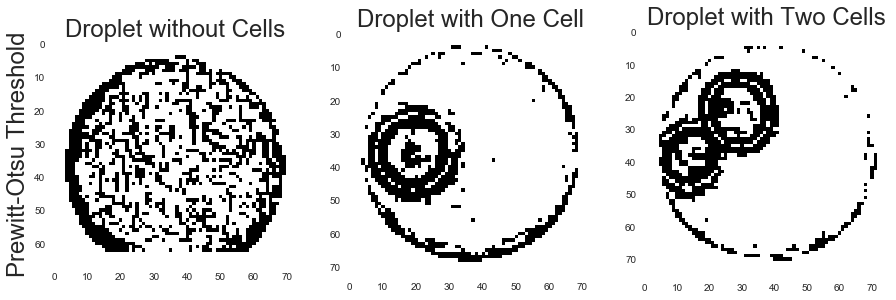

In [67]:
state_of_segment = [cell_segment_10x(x, test_gfp_droplets[i]) for i, x in enumerate(test_bw_droplets)]

with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    _ = ax[0].set_ylabel('Prewitt-Otsu Threshold', size=24)
    for i in range(3):
        _ = ax[i].imshow(state_of_segment[i])
        _ = ax[i].set_title(three_types[i], size=24)
    plt.show()
        

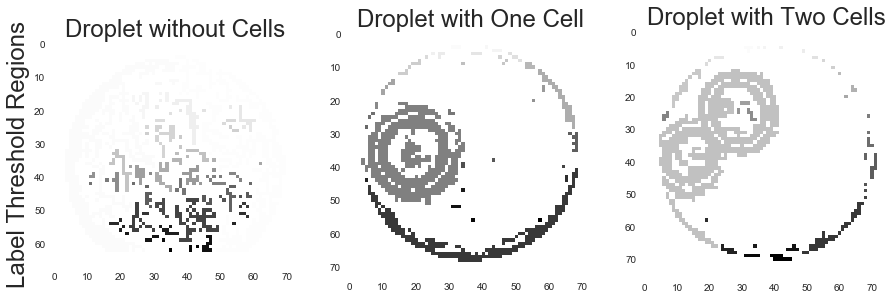

In [70]:
state_of_segment = [cell_segment_10x(x, test_gfp_droplets[i]) for i, x in enumerate(test_bw_droplets)]

with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    _ = ax[0].set_ylabel('Label Threshold Regions', size=24)
    for i in range(3):
        _ = ax[i].imshow(state_of_segment[i])
        _ = ax[i].set_title(three_types[i], size=24)
    plt.show()

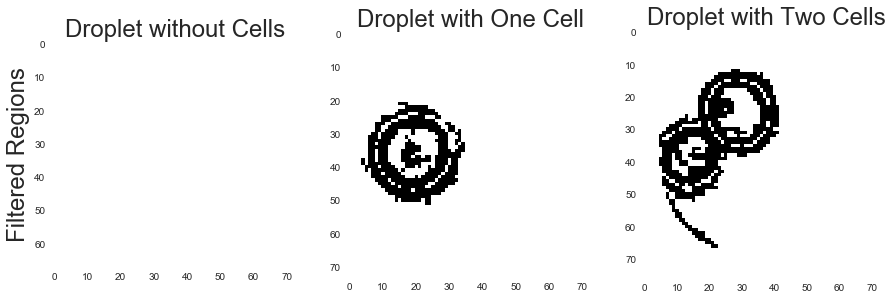

In [78]:
state_of_segment = [cell_segment_10x(x, test_gfp_droplets[i]) for i, x in enumerate(test_bw_droplets)]

with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    _ = ax[0].set_ylabel('Filtered Regions', size=24)
    for i in range(3):
        _ = ax[i].imshow(state_of_segment[i])
        _ = ax[i].set_title(three_types[i], size=24)
    plt.show()

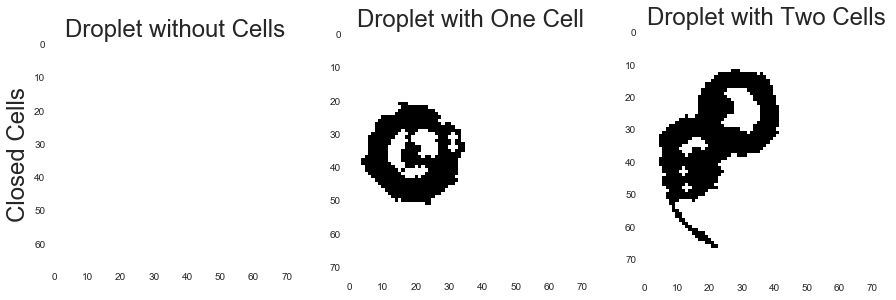

In [82]:
state_of_segment = [cell_segment_10x(x, test_gfp_droplets[i]) for i, x in enumerate(test_bw_droplets)]

with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    _ = ax[0].set_ylabel('Closed Cells', size=24)
    for i in range(3):
        _ = ax[i].imshow(state_of_segment[i])
        _ = ax[i].set_title(three_types[i], size=24)
    plt.show()

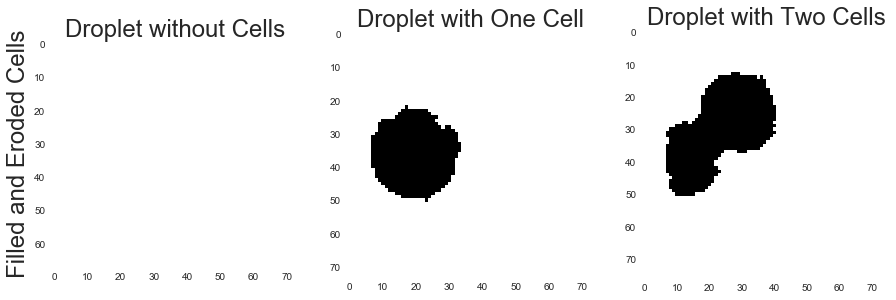

In [97]:
state_of_segment = [cell_segment_10x(x, test_gfp_droplets[i]) for i, x in enumerate(test_bw_droplets)]

with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    _ = ax[0].set_ylabel('Filled and Eroded Cells', size=24)
    for i in range(3):
        _ = ax[i].imshow(state_of_segment[i])
        _ = ax[i].set_title(three_types[i], size=24)
    plt.show()

In [261]:
state_of_segment = [cell_segment_10x(x, test_gfp_droplets[i]) for i, x in enumerate(test_bw_droplets)]

with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    _ = ax[0].set_ylabel('Separated Cells', size=24)
    for i in range(2,3):
        _ = ax[i].imshow(state_of_segment[i])
        _ = ax[i].set_title(three_types[i], size=24)
    plt.show()

2
0


TypeError: Invalid dimensions for image data

In [264]:
state_of_segment = [cell_segment_10x(x, test_gfp_droplets[i]) for i, x in enumerate(test_bw_droplets)]

2
0
1


In [252]:
# Inspect what should return two None values
no_cells = state_of_segment[0]
print(no_cells)

(None, None)


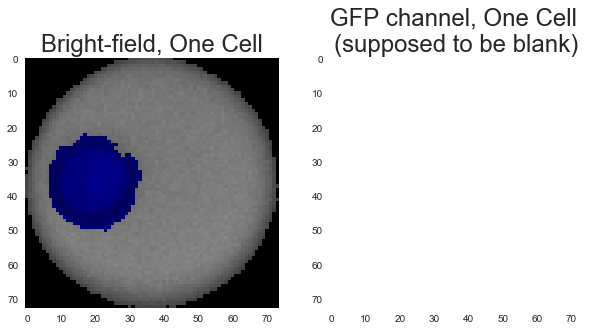

In [227]:
# Inspect what should return two lists, one should be an image of a 
# bright-field cell and the other should be blank
one_cell = state_of_segment[1]
one_bright = one_cell[0][0] 
not_one_bright = one_cell[0][0] == 0
one_gfp = one_cell[1][0]
rgb_one_bright = np.dstack(3 * [not_one_bright*test_bw_droplets[1]])
rgb_one_bright[:, :, 2] = one_bright + not_one_bright*test_bw_droplets[1]

with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    _ = ax[0].imshow(rgb_one_bright)
    _ = ax[0].set_title('Bright-field, One Cell', size=24)
    _ = ax[1].imshow(one_cell[1][0])
    _ = ax[1].set_title('GFP channel, One Cell \n(supposed to be blank)', size=24)
plt.show()

2


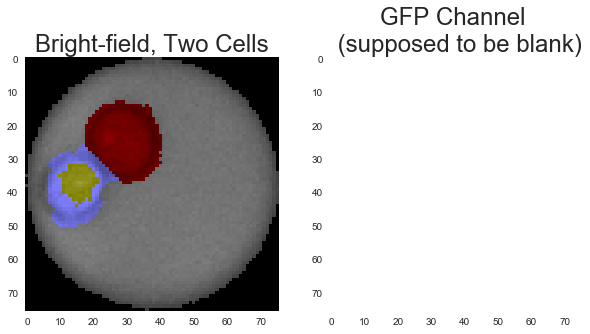

In [267]:
# Now show the two separated cells 
two_cell = state_of_segment[2]
print(len(two_cell[0]))
two_cell_1 = two_cell[0][0]
two_cell_2 = two_cell[0][1]
not_two_cell = two_cell[0][0] == 0
rgb_two_bright = np.dstack(3 * [not_two_cell*test_bw_droplets[2]])
rgb_two_bright[:, :, 0] = two_cell_1 + not_two_cell*test_bw_droplets[2]
rgb_two_bright[:, :, 2] = two_cell_2 + not_two_cell*test_bw_droplets[2]

with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    _ = ax[0].imshow(rgb_two_bright)
    _ = ax[0].set_title('Bright-field, Two Cells', size=24)
    _ = ax[1].imshow(two_cell[1][0])
    _ = ax[1].set_title('GFP Channel \n (supposed to be blank)', size=24)
plt.show()